# Imports

In [23]:
from PIL import Image
import numpy as np
import copy
import cv2 as cv
import os
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt
import seaborn as seab
import warnings

# import tensorflow as tf
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches

# from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter

warnings.filterwarnings("ignore")
import pandas as pd
from sklearn import metrics
np.set_printoptions(suppress=True) 

In [2]:
def heatmap(confusionmat,title="Confusion Matrix",title2="",index=0):
    plt.figure()
    ax = plt.axes()
    seab.heatmap(confusionmat,linewidths=0.4,linecolor='white',annot=True,fmt='g') 
    ax.set_title(title + title2)
def getConfusionMat(predicted, actual,classcount):
    confusionmatrix = []
    for i in range (classcount):
        confusionmatrix.append([])
        for j in range (classcount):
            confusionmatrix[i].append(0)
    for i in range(0, len(predicted)):
        confusionmatrix[actual[i]][predicted[i]]+=1
    return confusionmatrix

In [3]:
all_data = pd.read_csv("../Dataset/PS_20174392719_1491204439457_log.csv")

In [4]:
print len(all_data)

6362620


In [5]:
print all_data.keys()
all_data.shape

Index([u'step', u'type', u'amount', u'nameOrig', u'oldbalanceOrg',
       u'newbalanceOrig', u'nameDest', u'oldbalanceDest', u'newbalanceDest',
       u'isFraud', u'isFlaggedFraud'],
      dtype='object')


(6362620, 11)

In [6]:
print all_data.iloc[0,:]
all_data.head()

step                        1
type                  PAYMENT
amount                9839.64
nameOrig          C1231006815
oldbalanceOrg          170136
newbalanceOrig         160296
nameDest          M1979787155
oldbalanceDest              0
newbalanceDest              0
isFraud                     0
isFlaggedFraud              0
Name: 0, dtype: object


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# remove feature isFlagged fraud

In [7]:
new_all_data = pd.DataFrame()
new_all_data = new_all_data.append(all_data.loc[:,['step','type','amount','nameOrig','oldbalanceOrg','newbalanceOrig','nameDest','oldbalanceDest','newbalanceDest','isFraud']])

In [8]:
print len(new_all_data)

6362620


# Data Visualisations

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


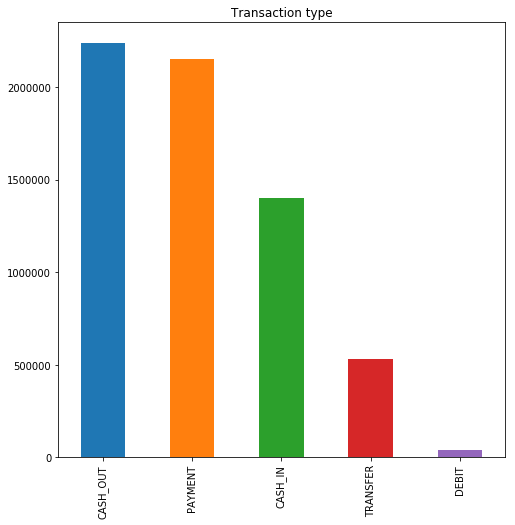

In [9]:
print(new_all_data.type.value_counts())

f, ax = plt.subplots(1, 1, figsize=(8, 8))
new_all_data.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

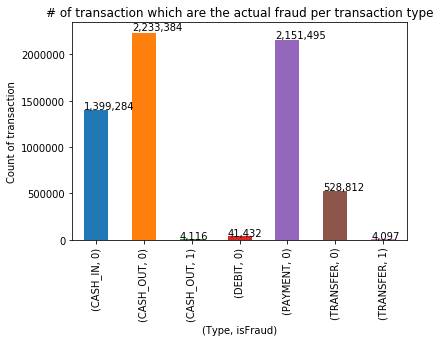

In [10]:
ax = new_all_data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

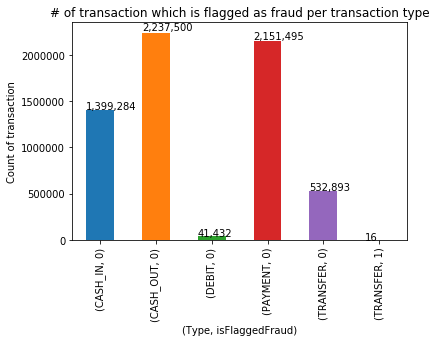

In [11]:
ax = all_data.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which is flagged as fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

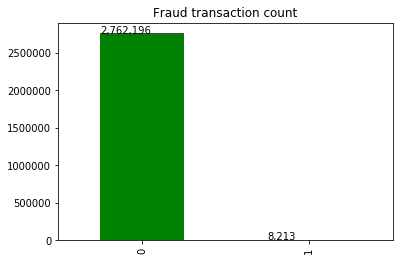

In [17]:
tmp = all_data.loc[(all_data['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
ax = pd.value_counts(tmp['isFraud'], sort = True).sort_index().plot(kind='bar',color = "green", title="Fraud transaction count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    
plt.show()

# Data Visualisation End

In [9]:
set(new_all_data.type)

{'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'}

In [27]:
# pop = fsga.generate(100)
new_filterdata = pd.DataFrame()

In [28]:
new_filterdata = pd.DataFrame()
new_filterdata= new_filterdata.append(new_all_data.loc[new_all_data.loc[:,'type'] == 'TRANSFER',:],ignore_index=True)
len(new_filterdata)
new_filterdata= new_filterdata.append(new_all_data.loc[new_all_data.loc[:,'type'] == 'CASH_OUT',:],ignore_index=True)
len(new_filterdata)
print new_filterdata.keys()

Index([u'step', u'type', u'amount', u'nameOrig', u'oldbalanceOrg',
       u'newbalanceOrig', u'nameDest', u'oldbalanceDest', u'newbalanceDest',
       u'isFraud'],
      dtype='object')


In [29]:
print set(new_filterdata.type)

set(['CASH_OUT', 'TRANSFER'])


In [30]:
new_filterdata.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1
1,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0
2,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0
3,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0
4,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0


In [37]:
copydata = copy.deepcopy(new_filterdata)

In [38]:
copydata.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2770404,742,CASH_OUT,63416.99,C994950684,63416.99,0.0,C1662241365,276433.18,339850.17,1
2770405,743,CASH_OUT,1258818.82,C1436118706,1258818.82,0.0,C1240760502,503464.50,1762283.33,1
2770406,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1
2770407,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1
2770408,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1


In [39]:
copydata.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1
1,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0
2,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0
3,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0
4,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0


In [40]:
# copydata.reset_index()

In [41]:
copydata.loc[copydata.type == 'TRANSFER', 'type'] = 0
copydata.loc[copydata.type == 'CASH_OUT', 'type'] = 1

In [42]:
copydata.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2770404,742,1,63416.99,C994950684,63416.99,0.0,C1662241365,276433.18,339850.17,1
2770405,743,1,1258818.82,C1436118706,1258818.82,0.0,C1240760502,503464.50,1762283.33,1
2770406,743,1,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1
2770407,743,1,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1
2770408,743,1,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1


In [43]:
print len(set(copydata.nameOrig))
print len(set(copydata.nameDest))

2768630
509565


In [47]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(X)
print  enc.categories_
print X
enc.transform(X).toarray()


[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]
[['Male', 1], ['Female', 3], ['Female', 2]]


array([[0., 1., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.]])

In [22]:
copydata.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,1,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1
1,1,1,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0
2,1,1,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0
3,1,1,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0
4,1,1,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0


In [23]:
# copy2 = copy.deepcopy(copydata)
# copy2.to_csv("../Dataset/filtereddata_withtypeconverted",index=False)

In [24]:
# copydata = copy.deepcopy(copy2)
unique_nameOrig = set(copydata.nameOrig)
unique_nameDest = set(copydata.nameDest)

In [25]:
print len(set(copydata.nameOrig))
print len(set(copydata.nameDest))

2768630
509565


In [29]:
print len(copydata.nameDest)

2770409


In [30]:
listdata = np.array(copydata)

In [31]:
print listdata[0]

[1 1 181.0 'C1305486145' 181.0 0.0 'C553264065' 0.0 0.0 1]


In [32]:
tmpunique = unique_nameDest.union(unique_nameOrig)
index = 1
tmpdict = {}
for i in range(len(listdata)):
    if(listdata[i][3] in tmpdict):
        listdata[i][3] = tmpdict[listdata[i][3]]
    else:
        tmpdict[listdata[i][3]] = index
        listdata[i][3] = index
        index += 1
    if(listdata[i][6] in tmpdict):
        listdata[i][6] = tmpdict[listdata[i][6]]
    else:
        tmpdict[listdata[i][6]] = index
        listdata[i][6] = index
        index += 1

In [33]:
print listdata[0]

[1 1 181.0 1 181.0 0.0 2 0.0 0.0 1]


In [26]:
newdataframe = pd.DataFrame(listdata,columns=copydata.keys())

NameError: name 'listdata' is not defined

In [35]:
# newdataframe

In [36]:
# newdataframe.to_csv("../Dataset/completepreprocesseddata.csv",index=False)

In [37]:
train_data = newdataframe.loc[:,['step','type','amount','nameOrig','oldbalanceOrg','newbalanceOrig','nameDest','oldbalanceDest','newbalanceDest']]

In [38]:
train_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,1,181,1,181,0,2,0,0
1,1,1,215310,3,705,0,4,22425,0
2,1,1,311686,5,10835,0,6,6267,2.71917e+06
3,1,1,62610.8,7,79114,16503.2,8,517,8383.29
4,1,1,42712.4,9,10363.4,0,10,57901.7,24044.2


In [40]:
train_labels = newdataframe.loc[:,['isFraud']]

In [41]:
train_labels.head()

,isFraud
0,1
1,0
2,0
3,0
4,0


In [42]:
# train_data.to_csv("../Dataset/train_data.csv",index=False)
# train_labels.to_csv("../Dataset/train_labels.csv",index=False)

In [43]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [44]:
# clf = SVC(gamma='auto')
clf = GaussianNB()
clf.fit(np.array(train_data),np.array(train_labels).astype(int))

GaussianNB(priors=None, var_smoothing=1e-09)

In [48]:
# y = clf.predict(np.array(train_data))
# print "Accuracy on Train Data: " +str( accuracy_score(y,np.array(train_labels).astype(int)))
# heatmap(getConfusionMat(predicted=y,actual=np.array(train_labels.isFraud).astype(int),classcount=2),title2=" with GaussianNB")

In [65]:
print "Count of Non Fraud Transactions: " +str(list(np.array(train_labels).astype(int)).count(0))

Count of Non Fraud Transactions: 2762196


In [61]:
print "Count of Fraud Transactions: " +str(list(np.array(train_labels).astype(int)).count(1))

Count of Fraud Transactions: 8213


In [67]:
print "Percentage of Non Fraud Transactions: " +str(list(np.array(train_labels).astype(int)).count(0)/float(len(train_labels)) * 100)
print "Percentage of Fraud Transactions: " +str(list(np.array(train_labels).astype(int)).count(1)/float(len(train_labels)) * 100)

Percentage of Non Fraud Transactions: 99.7035455776
Percentage of Fraud Transactions: 0.296454422434


In [58]:
#Transfer
dfFraudTransfer = newdataframe.loc[(newdataframe.isFraud == 1) & (newdataframe.type == 1)]
#Cashout
dfFraudCashout = newdataframe.loc[(newdataframe.isFraud == 1) & (newdataframe.type == 2)]

print ('\n Fraudulent TRANSFER count = '+str(len(dfFraudTransfer))) # 4097

print ('\n Fraudulent CASH_OUT count= '+str(len(dfFraudCashout))) 


 Fraudulent TRANSFER count = 4097

 Fraudulent CASH_OUT count= 4116


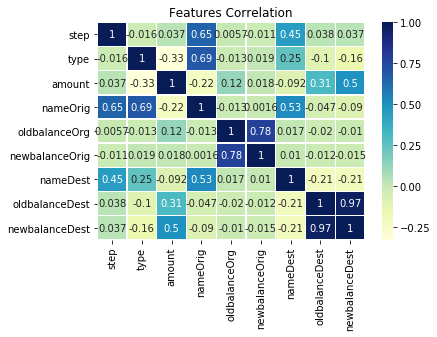

In [48]:
corr = train_data.astype(float).corr()
ax = plt.axes()
ax.set_title("Features Correlation")
seab.heatmap(corr,linewidths=0.4,linecolor='white',annot=True,cmap ="YlGnBu")

In [25]:
train_data_correlation = newdataframe.loc[:,['step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest']]

NameError: name 'newdataframe' is not defined

In [57]:
train_data_correlation.tail()

,step,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest
2770404,742,2,63417,63417,0,766935,276433
2770405,743,2,1.25882e+06,1.25882e+06,0,312633,503464
2770406,743,2,339682,339682,0,3277507,0
2770407,743,2,6.31141e+06,6.31141e+06,0,1736898,68488.8
2770408,743,2,850003,850003,0,74835,6.5101e+06


In [58]:
train_labels.tail()

,isFraud
2770404,1
2770405,1
2770406,1
2770407,1
2770408,1


In [69]:
# from sklearn.manifold import TSNE
# X_embedded = TSNE(n_components=2).fit_transform(np.array(train_data_correlation))
print int(train_labels.iloc[0] == 1)

1


In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
scatter_X = pca.fit_transform(np.array(train_data_correlation))
for i in range(0,len(scatter_X)):
    if(int(train_labels.iloc[i] == 1) == 1):
        color = 'red'
        else:
            color = 'blue'
        plt.scatter(scatter_X[i][0],scatter_X[i][1],c=color)

KeyboardInterrupt: 

Error in callback <function post_execute at 0x7f7ac5a21578> (for post_execute):


ValueError: object too deep for desired array

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/ashish/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ashish/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ashish/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ashish/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ashish/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ashish/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history,

In [51]:
from sklearn import metrics
probabilities = clf.predict_proba(np.array(train_labels).astype(int))
mett=metrics.classification_report(np.array(train_labels.isFraud).astype(int),y)
print mett
p,r,t = metrics.precision_recall_curve(probas_pred=probabilities[:,0],y_true=np.array(train_labels.isFraud).astype(int))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   2762196
           1       0.08      0.40      0.13      8213

   micro avg       0.98      0.98      0.98   2770409
   macro avg       0.54      0.69      0.56   2770409
weighted avg       1.00      0.98      0.99   2770409



In [18]:
# plt.plot(r, p, marker='^')

In [122]:
train_data = np.array(train_data)
train_labels = np.array(train_labels).astype(int)

In [123]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)
trainX, testX, trainY, testY = train_test_split(train_data, train_labels, test_size = 0.2)

In [157]:
# clf = SVC(gamma='auto')
clf = GaussianNB()
clf.fit(trainX,trainY)

GaussianNB(priors=None, var_smoothing=1e-09)

Accuracy on Train Data: 0.9845149273934183


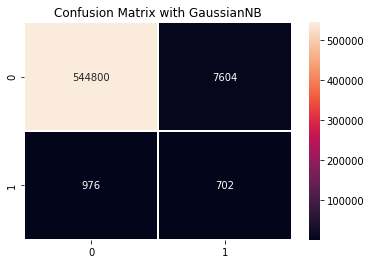

In [160]:
y = clf.predict(testX)
print "Accuracy on Train Data: " +str( accuracy_score(y_true=testY,y_pred=y))
heatmap(getConfusionMat(predicted=y,actual=testY.flatten(),classcount=2),title2=" with GaussianNB")

In [134]:
print testY.shape

(554082, 1)


In [135]:
print y.shape

(554082,)
